## This version does the ZOGY but computes the kernels in fourier space, and then convolves images in real space.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

In [2]:
x = np.arange(-16, 16, 1)
y = x.copy()
y0, x0 = np.meshgrid(x, y)
grid = np.dstack((y0, x0))

Make the two "images". `im1` is the template, `im2` is the science image.

NOTE: having sources near the edges really messes up the fitting (probably because of the convolution). So make sure no sources are near the edge.

NOTE: also it seems that having the variable source with a large flux increase also messes up the fitting (seems to lead to overfitting -- perhaps to the source itself). This might be fixed by adding more constant sources.

Use the code from `diffimTests.py`.

In [3]:
import diffimTests as dit
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

im1, im2, im1_psf, im2_psf, im1_var, im2_var, changedCentroid = \
    dit.makeFakeImages(xim=None, yim=None, sky=sky, psf1=None, psf2=None, offset=[0., 0.],
                    psf_yvary_factor=0., varSourceChange=1500., theta1=0., theta2=-45., im2background=0.,
                    n_sources=50, sourceFluxRange=(500,30000), seed=66, psfSize=None)
    
_, _, P_r, P_n, _, _, changedCentroid = \
    dit.makeFakeImages(xim=None, yim=None, sky=sky, psf1=None, psf2=None, offset=[0., 0.],
                    psf_yvary_factor=0., varSourceChange=1500., theta1=0., theta2=-45., im2background=0.,
                    n_sources=50, sourceFluxRange=(500,30000), seed=66, psfSize=25)

print dit.computeClippedImageStats(im1)
print dit.computeClippedImageStats(im2)
print dit.computeClippedImageStats(im1_var)
print dit.computeClippedImageStats(im2_var)

LSSTSW has not been set up.
LSSTSW has not been set up.
Template PSF: [1.6, 1.6] 0.0
Science PSF: [1.8, 2.2] -45.0
0.824621125124
Offset: [0.0, 0.0]
PSF y spatial-variation: 0.0 0.0
Variable source: 245.899250131 279.361590046 1423.89964966 2923.89964966
Template PSF: [1.6, 1.6] 0.0
Science PSF: [1.8, 2.2] -45.0
0.824621125124
Offset: [0.0, 0.0]
PSF y spatial-variation: 0.0 0.0
Variable source: 245.899250131 279.361590046 1423.89964966 2923.89964966
(0.058941207521673616, 17.142582277831181, -74.0, 1741.5550996425638)
(0.16735074378053241, 17.213851327082029, -82.0, 1169.0572762553779)
(300.05894120752163, 17.142582277831185, 226.0, 2041.5550996425638)
(300.16735074378062, 17.213851327082025, 218.0, 1469.0572762553779)


In [4]:
reload(dit)
D = dit.performZOGY(im1, im2, im1_psf, im2_psf)
D_AL, _ = dit.performAlardLupton(im1, im2, spatialKernelOrder=0, spatialBackgroundOrder=1)
D_AL /= np.sqrt(sky * 2.)
D_new = dit.performZOGYImageSpace(im1, im2, P_r, P_n)
print dit.computeClippedImageStats(D)
print dit.computeClippedImageStats(D_new)
print dit.computeClippedImageStats(D_AL)

LSSTSW has not been set up.
(-0.00088461625188954456, 0.99323103780108224, -4.8991482379795386, 4.4838171160544444)
(-0.00093387909474006441, 0.99316652235271219, -4.8991388063002583, 4.4849793578717669)
(-0.0032574651151795384, 0.98643447728621669, -4.7439403672639049, 5.8392332955930497)


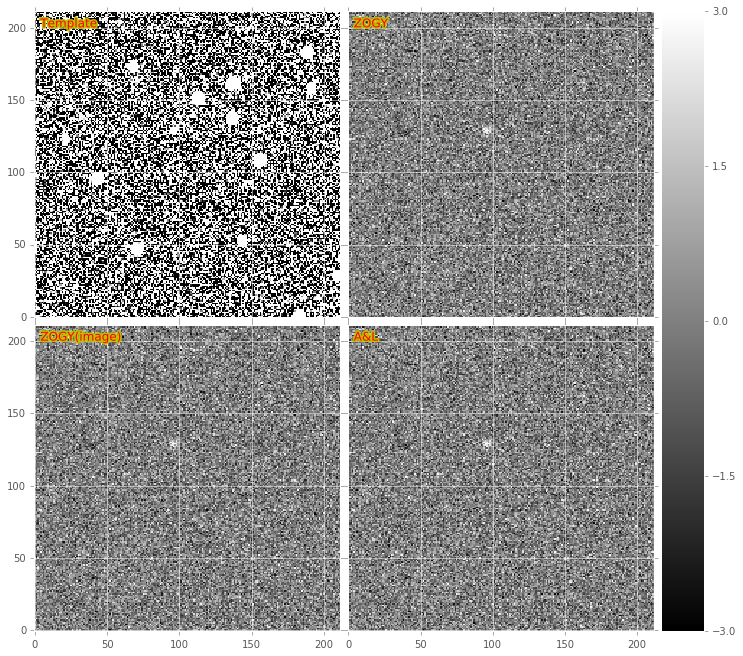

In [5]:
xim = np.arange(-256, 256, 1)
yim = xim.copy()
y0im, x0im = np.meshgrid(xim, yim)
imgrid = np.dstack((y0im, x0im))

fig = plt.figure(1, (12, 12))
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
dit.plotImageGrid((im1[x1d:x2d,y1d:y2d], D[x1d:x2d,y1d:y2d], D_new[x1d:x2d,y1d:y2d], D_AL[x1d:x2d,y1d:y2d]), 
                  clim=(-3,3), titles=['Template', 'ZOGY', 'ZOGY(image)', 'A&L'])

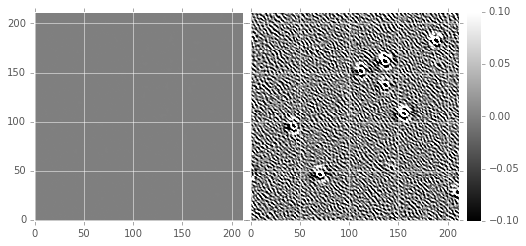

In [6]:
D_new[0,:] = D_new[:,0] = D_new[-1,:] = D_new[:,-1] = 0.
D[D_new == 0] = 0.
D_AL[D_new == 0] = 0.
fig = plt.figure(1, (8, 8))
dit.plotImageGrid(((D - D_new)[x1d:x2d,y1d:y2d], (D_new - D_AL)[x1d:x2d,y1d:y2d]), clim=(-0.1, 0.1))

Work on variance planes.

LSSTSW has not been set up.
(0.010789724825635743, 0.9787012067583204, -4.5284690834152022, 9.127204265070894)
(6.9142543371431356e-05, 0.006198303716639147, -0.028623117289244805, 0.063284775402080731)
(245.89925013100506, 279.36159004560153) 9.12720426507
29


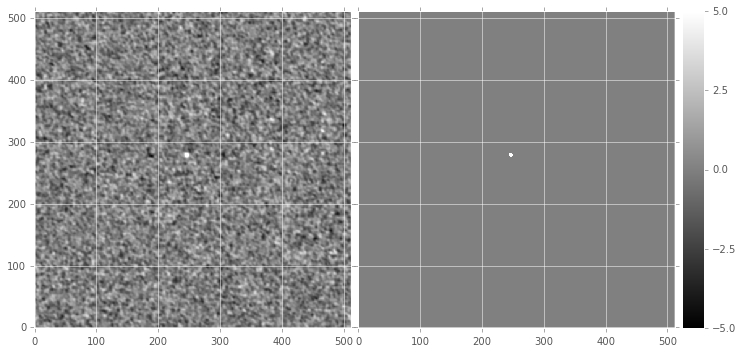

In [7]:
reload(dit);

S_corr, S, D, P_D, F_D = dit.performZOGY_Scorr(im1, im2, im1_var, im2_var, P_r, P_n)
print dit.computeClippedImageStats(S_corr)
print dit.computeClippedImageStats(S)
#dit.plotImageGrid((S_corr, S, var1c, var2c), clim=(-2,2))
print changedCentroid, S_corr[np.rint(changedCentroid[1]).astype(int), np.rint(changedCentroid[0]).astype(int)]
print (S_corr > 5.).sum() + (S_corr < -5.).sum()
fig = plt.figure(1, (12, 12))
dit.plotImageGrid((S_corr, ((S_corr > 5.)*5.0 + (S_corr < -5.)*-5.0)), clim=(-5.,5.))

Try the matched filtering with the A&L diffim...

(-0.0028586869122688048, 0.95882182312001629, -4.5176044410688787, 9.0801944756893569)
(-1.8018251139560329e-05, 0.0060756716898208614, -0.028554445089776021, 0.062958826307888252)
(245.89925013100506, 279.36159004560153) 9.08019447569
26


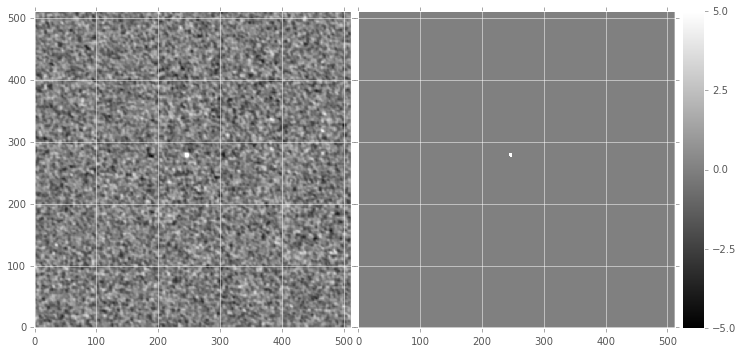

In [8]:
S_corr, S, D, P_D, F_D = dit.performZOGY_Scorr(im1, im2, im1_var, im2_var, P_r, P_n, D=D_AL)
print dit.computeClippedImageStats(S_corr)
print dit.computeClippedImageStats(S)
#dit.plotImageGrid((S_corr, S, var1c, var2c), clim=(-2,2))
print changedCentroid, S_corr[np.rint(changedCentroid[1]).astype(int), np.rint(changedCentroid[0]).astype(int)]
print (S_corr > 5.).sum() + (S_corr < -5.).sum()
fig = plt.figure(1, (12, 12))
dit.plotImageGrid((S_corr, ((S_corr > 5.)*5.0 + (S_corr < -5.)*-5.0)), clim=(-5.,5.))

### Try the reverse case where science is narrower than template...

In [29]:
reload(dit)
D = dit.performZOGY(im2, im1, im2_psf, im1_psf)
D_AL, _ = dit.performAlardLupton(im2, im1, spatialKernelOrder=0, spatialBackgroundOrder=1)
D_AL /= np.sqrt(sky * 2.)
D_new = dit.performZOGYImageSpace(im2, im1, P_n, P_r)
print dit.computeClippedImageStats(D)
print dit.computeClippedImageStats(D_new)
print dit.computeClippedImageStats(D_AL)

LSSTSW has not been set up.
(0.00088461625188954456, 0.99323103780108224, -4.4838171160544444, 4.8991482379795386)
(0.00093387909474006441, 0.99316652235271219, -4.4849793578717669, 4.8991388063002583)
(-0.0038024902965097091, 0.96445525121396791, -6.7474872053872987, 19.311547030465636)


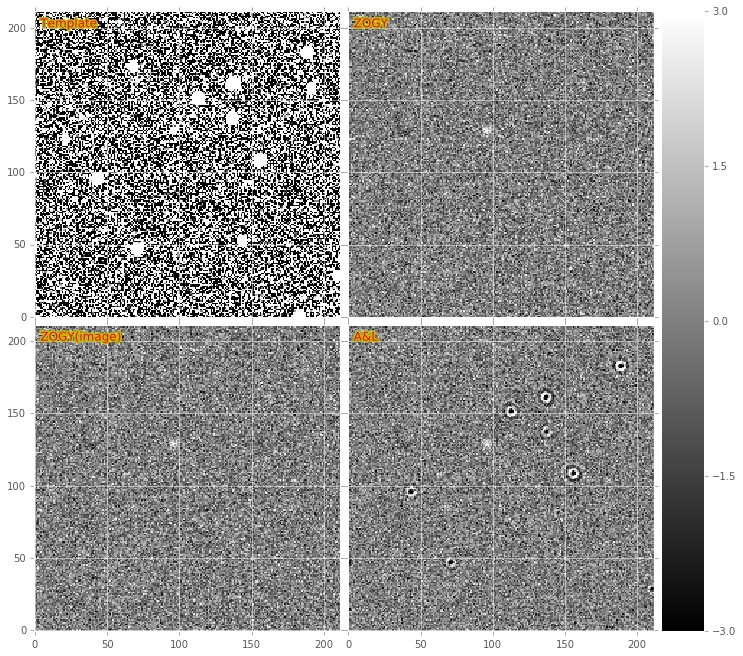

In [30]:
xim = np.arange(-256, 256, 1)
yim = xim.copy()
y0im, x0im = np.meshgrid(xim, yim)
imgrid = np.dstack((y0im, x0im))

fig = plt.figure(1, (12, 12))
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
dit.plotImageGrid((im1[x1d:x2d,y1d:y2d], -D[x1d:x2d,y1d:y2d], -D_new[x1d:x2d,y1d:y2d], -D_AL[x1d:x2d,y1d:y2d]), 
                  clim=(-3,3), titles=['Template', 'ZOGY', 'ZOGY(image)', 'A&L'])

LSSTSW has not been set up.
(-0.010789724825635743, 0.9787012067583204, -9.127204265070894, 4.5284690834152022)
(-6.9142543371431356e-05, 0.006198303716639147, -0.063284775402080731, 0.028623117289244805)
(245.89925013100506, 279.36159004560153) -9.12720426507
29


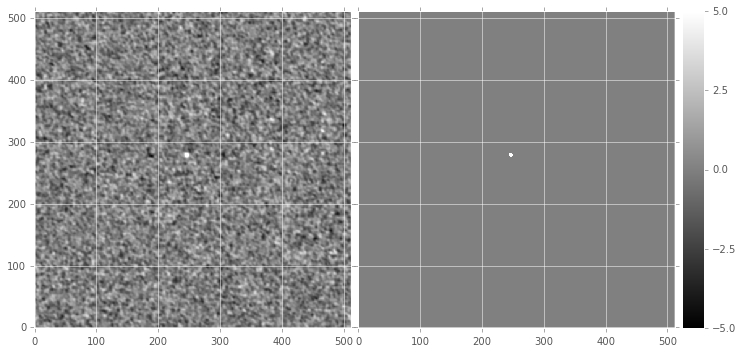

In [31]:
reload(dit);

S_corr, S, D, P_D, F_D = dit.performZOGY_Scorr(im2, im1, im2_var, im1_var, P_n, P_r)
print dit.computeClippedImageStats(S_corr)
print dit.computeClippedImageStats(S)
#dit.plotImageGrid((S_corr, S, var1c, var2c), clim=(-2,2))
print changedCentroid, S_corr[np.rint(changedCentroid[1]).astype(int), np.rint(changedCentroid[0]).astype(int)]
print (S_corr > 5.).sum() + (S_corr < -5.).sum()
fig = plt.figure(1, (12, 12))
dit.plotImageGrid((-S_corr, ((S_corr > 5.)*-5.0 + (S_corr < -5.)*5.0)), clim=(-5.,5.))

(-0.0034244474487314558, 0.89343056719144276, -8.1234007185685808, 6.0760249985838239)
(-2.4141440847164497e-05, 0.0056544270994208319, -0.05632476003008801, 0.077436705817697529)
(245.89925013100506, 279.36159004560153) -8.12340071857
40


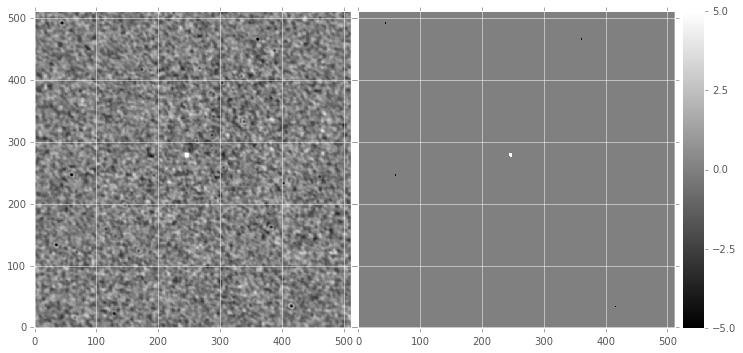

In [79]:
S_corr, S, _, P_D, F_D = dit.performZOGY_Scorr(im2, im1, im2_var, im1_var, P_n, P_r, D=D_AL)
print dit.computeClippedImageStats(S_corr)
print dit.computeClippedImageStats(S)
#dit.plotImageGrid((S_corr, S, var1c, var2c), clim=(-2,2))
print changedCentroid, S_corr[np.rint(changedCentroid[1]).astype(int), np.rint(changedCentroid[0]).astype(int)]
print (S_corr > 5.).sum() + (S_corr < -5.).sum()
fig = plt.figure(1, (12, 12))
dit.plotImageGrid((-S_corr, ((S_corr > 5.)*-5.0 + (S_corr < -5.)*5.0)), clim=(-5.,5.))

### But now turn on A&L "preconvolution" with the correct decorrelation kernel enabled...

In [ ]:
reload(dit)

# Note kernelSize needs to equal psfSize in makeFakeImages call above

D_AL_pc, kappa = dit.performAlardLupton(im2, im1, spatialKernelOrder=0, spatialBackgroundOrder=1, 
                                        preConvKernel=P_n, kernelSize=25, doALZCcorrection=False)
D_AL_pc_ALZC, kappa2 = dit.performAlardLupton(im2, im1, spatialKernelOrder=0, spatialBackgroundOrder=1, 
                                        preConvKernel=P_n, kernelSize=25, doALZCcorrection=True)
print dit.computeClippedImageStats(D_AL_pc)
print dit.computeClippedImageStats(D_AL_pc_ALZC)

LSSTSW has not been set up.


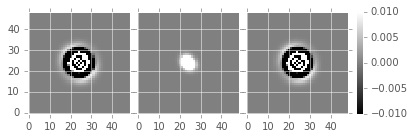

In [94]:
dit.plotImageGrid((kappa, P_n, kappa2), clim=(-0.01,0.01))

(-6.9142543371431356e-05, 0.006198303716639147, -0.063284775402080731, 0.028623117289244805)
(-0.010789724825635743, 0.9787012067583204, -9.127204265070894, 4.5284690834152022)


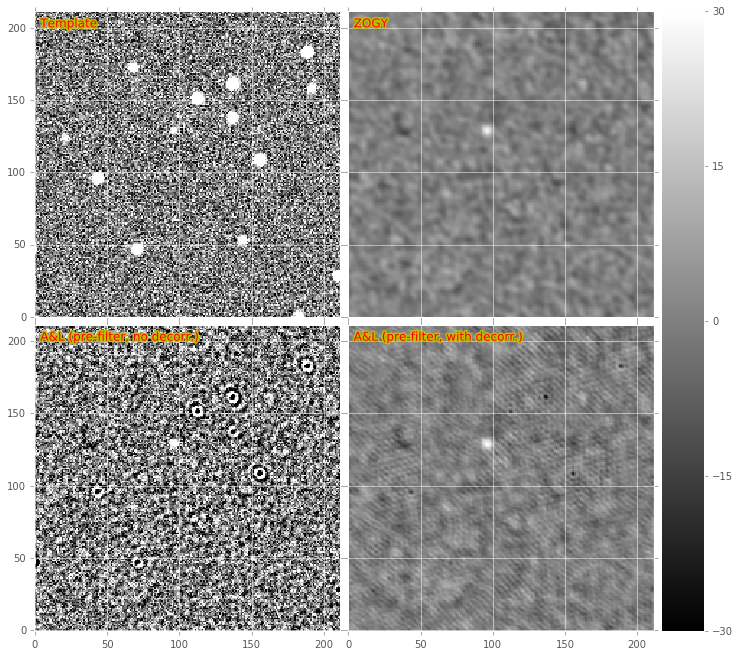

In [96]:
S_corr, S, D, P_D, F_D = dit.performZOGY_Scorr(im2, im1, im2_var, im1_var, P_n, P_r)
print dit.computeClippedImageStats(S)
print dit.computeClippedImageStats(S_corr)

xim = np.arange(-256, 256, 1)
yim = xim.copy()
y0im, x0im = np.meshgrid(xim, yim)
imgrid = np.dstack((y0im, x0im))

fig = plt.figure(1, (12, 12))
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
dit.plotImageGrid((im1[x1d:x2d,y1d:y2d], -S_corr[x1d:x2d,y1d:y2d]*3., -D_AL_pc[x1d:x2d,y1d:y2d], 
                   -D_AL_pc_ALZC[x1d:x2d,y1d:y2d]), 
                  clim=(-30,30), titles=['Template', 'ZOGY', 'A&L (pre-filter, no decorr.)', 
                                         'A&L (pre-filter, with decorr.)'])

(1.0110925154661106, 0.94379274932239154, -71210.482182761567, 144824.18786344165)


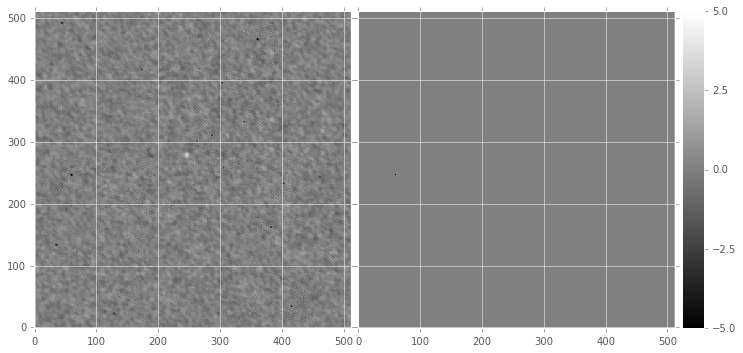

In [99]:
print dit.computeClippedImageStats(D_AL_pc_ALZC/S_corr)
#D_AL_pc_ALZC /= 3.0
print (D_AL_pc_ALZC > 15.).sum() + (D_AL_pc_ALZC < -15.).sum()
fig = plt.figure(1, (12, 12))
dit.plotImageGrid((-D_AL_pc_ALZC, ((D_AL_pc_ALZC > 15.)*-15.0 + (D_AL_pc_ALZC < -15.)*15.0)), clim=(-15.,15.))